# Curvature combs

<img src="../images/curvature-combs.png" width="640">

I'm not sure when the first time I saw a curvature comb was. I always felt that I intuitively understood them, but only recently did I realize that I don't actually know how to implement them. Which is a good clue that I didn't really understand them!

With help from the [Wikipedia article on Curvature](https://en.wikipedia.org/wiki/Curvature) and Pomax' excellent [Primer on Bézier Curves](https://pomax.github.io/bezierinfo/), I managed to figure it out.

Let's start by defining a function for a quadratic bézier segment, and to render it with matplotlib:

In [87]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt

def quadratic_bezier(p0, p1, p2, t):
    """Calculate the point on a quadratic Bezier curve at a parameter t."""
    return (1 - t)**2 * jnp.array(p0) + 2 * (1 - t) * t * jnp.array(p1) + t**2 * jnp.array(p2)

def show_curve(points):
    p0, p1, p2 = points
    t_values = jnp.linspace(0, 1, num=100)
    sample_points = jnp.array([quadratic_bezier(p0, p1, p2, t) for t in t_values])
    plt.plot(sample_points[:, 0], sample_points[:, 1], 'r-')  # Curve in red
    plt.plot([p0[0], p1[0], p2[0]], [p0[1], p1[1], p2[1]], 'go--')  # Control points in green

Here's the example we'll work with:

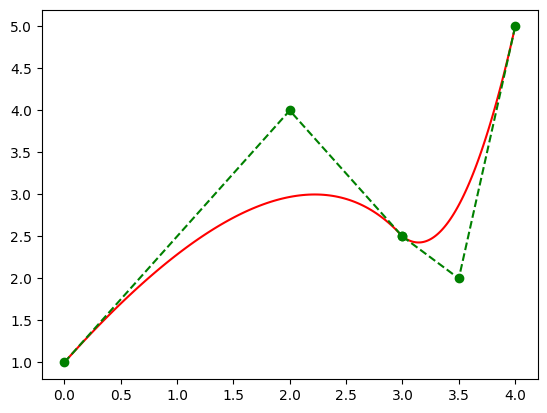

In [88]:
c1 = [[0, 1], [2, 4], [3, 2.5]]
c2 = [c1[2], [3.5, 2], [4, 5]]
show_curve(c1)
show_curve(c2)

The comb is a visualization of the curvature at a given point on the curve. To calculate the curvature, we need the first and second derivatives. We can use the JAX `grad` function to do this:

In [89]:
def bezier_x(p0, p1, p2, t):
    return quadratic_bezier(p0, p1, p2, t)[0]

def bezier_y(p0, p1, p2, t):
    return quadratic_bezier(p0, p1, p2, t)[1]

# Differentiate coordinates separately
dx_dt = grad(bezier_x, argnums=3)
dy_dt = grad(bezier_y, argnums=3)

# Second derivatives
d2x_dt2 = grad(dx_dt, argnums=3)
d2y_dt2 = grad(dy_dt, argnums=3)

The curvature — known as κ (kappa) — is defined as:

<img src="../images/curvature-kappa.png" width="640">

(From [§26 Curvature](https://pomax.github.io/bezierinfo/#curvature) in _A Primer on Bézier Curves_.)

In [90]:
def kappa_qb(points, t):
    """Compute curvature at t using the formula for 2D curves."""
    p0, p1, p2 = points
    x_dot = dx_dt(p0, p1, p2, t)
    y_dot = dy_dt(p0, p1, p2, t)
    x_ddot = d2x_dt2(p0, p1, p2, t)
    y_ddot = d2y_dt2(p0, p1, p2, t)
    
    numerator = x_dot * y_ddot - y_dot * x_ddot
    denominator = (x_dot**2 + y_dot**2) ** 1.5
    return numerator / denominator

The curvature is just a ratio, and we could visualize it any number of ways. For example, here's a scatter plot where the color shows the curvature:

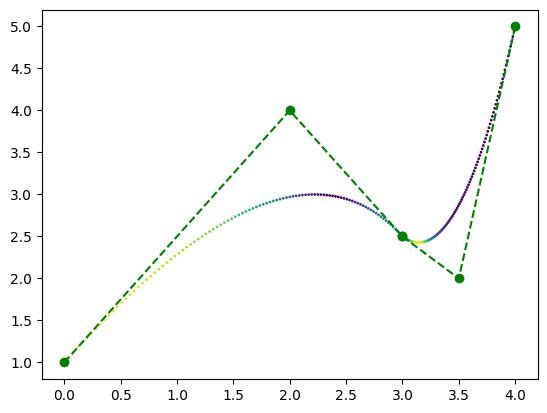

In [91]:
def show_curve_scatter(points):
    p0, p1, p2 = points
    t_values = jnp.linspace(0, 1, num=100)
    sample_points = jnp.array([quadratic_bezier(p0, p1, p2, t) for t in t_values])
    colors = [kappa_qb(points, t) for t in t_values]  # Sample color for each point
    plt.scatter(sample_points[:, 0], sample_points[:, 1], c=colors, s=1)  # Curve with sampled colors
    plt.plot([p0[0], p1[0], p2[0]], [p0[1], p1[1], p2[1]], 'go--')  # Control points in green

show_curve_scatter(c1)
show_curve_scatter(c2)

A curvature comb is just another visualization of the same data — where we render a normal to the curve, whose length is proportional to the curvature at that point.

We can use the first derivatives that we calculated earlier to find the unit tangent at a given point. The norm is at 90° to that — but the direction we choose is arbitrary.

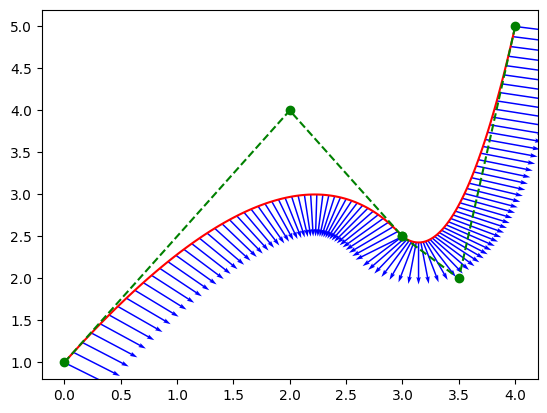

In [92]:
def unit_tangent(points, t):
    p0, p1, p2 = points
    v = jnp.array([dx_dt(p0, p1, p2, t), dy_dt(p0, p1, p2, t)])
    return v / jnp.linalg.norm(v)
    
def unit_norm(points, t):
    x, y = unit_tangent(points, t)
    return jnp.array([y, -x])

def show_norm(points):
    p0, p1, p2 = points
    for t in jnp.linspace(0, 1, num=50):
        p = quadratic_bezier(p0, p1, p2, t)
        v = unit_norm(points, t)
        plt.quiver(p[0], p[1], v[0], v[1], color='blue', scale=2, scale_units='xy', angles='xy', width=0.003)

show_curve(c1)
show_curve(c2)
show_norm(c1)
show_norm(c2)

Finally, to show the comb we just need to scale the length of the unit norm by the curvature value. Note that `kappa_qb` returns the _signed_ curvature, so after scaling, the vectors may point in the opposite direction.

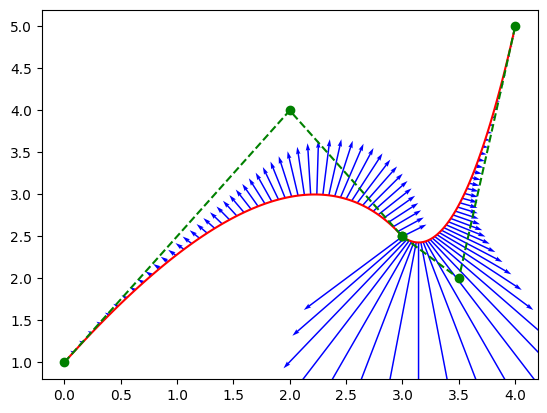

In [93]:
def show_comb(points):
    p0, p1, p2 = points

    t_values = jnp.linspace(0, 1, num=50)
    for t in t_values:
        p = quadratic_bezier(p0, p1, p2, t)
        v = unit_norm(points, t) * kappa_qb(points, t)
        plt.quiver(p[0], p[1], v[0], v[1], color='blue', scale=2, scale_units='xy', angles='xy', width=0.003)

show_curve(c1)
show_curve(c2)
show_comb(c1)
show_comb(c2)

A few things to note:

- The scale is arbitrary: only the _relative_ length of the lines matters. I think that's because the curvature at a given point could be arbitrarily high.
- In this implementation, the lines in the comb are not evenly spaced. To do that, you'd need the _arc length parameterization_ of the curve.